In [24]:
import pandas as pd
import numpy as np
import ast

In [25]:
INPUT_ALLOCATIONS = "allocations/obermeyer/allocations_sr_50_qr_75.csv"
QUALIFICATION_COLUMN = 'threshold_25' # 75th percentile translates to 25% qualification

In [26]:
df = pd.read_csv(INPUT_ALLOCATIONS)
df['selected'] = df['selected'].apply(ast.literal_eval)
df['unselected'] = df['unselected'].apply(ast.literal_eval)
df.head()

,seed,iteration,allocation_idx,selected,unselected,k',n',model_count
0,0,0,0,"[83, 799, 2217, 2674, 2811, 2903, 2999, 3126, ...","[25525, 35439, 1615, 17799, 15362, 36043, 4198...",47,75,1
1,0,1,0,"[339, 1896, 3602, 5395, 7074, 8704, 9136, 1101...","[46889, 41011, 28019, 3102, 15463, 23367, 3981...",46,81,1
2,0,1,1,"[339, 1896, 3602, 5395, 7074, 8704, 9131, 9136...","[46889, 41011, 28019, 3102, 15463, 23367, 3981...",46,81,2
3,0,1,2,"[339, 1896, 3602, 5395, 7074, 8704, 9136, 1101...","[46889, 41011, 28019, 3102, 15463, 23367, 3981...",46,81,1
4,0,1,3,"[339, 1896, 3602, 5395, 7074, 8704, 9136, 1101...","[46889, 41011, 28019, 3102, 15463, 23367, 3981...",46,81,1


In [27]:
data = pd.read_csv("data/obermeyer/obermeyer_data_cleaned.csv")
data.head()

,cost_t,race,dem_female,dem_age_band_18-24_tm1,dem_age_band_25-34_tm1,dem_age_band_35-44_tm1,dem_age_band_45-54_tm1,dem_age_band_55-64_tm1,dem_age_band_65-74_tm1,dem_age_band_75+_tm1,...,cost_other_tm1,cost_pharmacy_tm1,cost_physical_therapy_tm1,cost_radiology_tm1,gagne_sum_tm1,gagne_sum_t,threshold_25,threshold_50,threshold_75,person_id
0,0.002180,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.003623,0.000065,0.0,0.000000,0.000000,0,1,0,0,0
1,0.004723,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.032091,0.000065,0.0,0.014486,0.222222,3,1,0,0,1
2,0.000908,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000065,0.0,0.000000,0.000000,0,0,0,0,2
3,0.002361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000065,0.0,0.000000,0.000000,0,1,0,0,3
4,0.001998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.001035,0.000065,0.0,0.000000,0.055556,1,0,0,0,4


#### K' = Number of Qualified Selected
#### N' = Number of Qualified in Test Set

In [5]:
print(np.mean(df["k'"]))
print(np.std(df["k'"]))
print(np.mean(df["n'"]))
print(np.std(df["n'"]))

45.68392370572207
1.7754265326748322
76.9775204359673
3.280096256810468


#### Number of Rashomon Allocations
#### Number of Rashomon Models
#### Number of Rashomon Models Per Allocation


In [6]:
unique_allocations = df.groupby(["seed", "iteration"]).count()["allocation_idx"].reset_index()
print(np.mean(unique_allocations["allocation_idx"]))
print(np.std(unique_allocations["allocation_idx"]))
print()
unique_allocations = df.groupby(["seed", "iteration"]).sum()["model_count"].reset_index()
print(np.mean(unique_allocations["model_count"]))
print(np.std(unique_allocations["model_count"]))
print()
print(np.mean(df["model_count"]))
print(np.std(df["model_count"]))
print()

11.744
14.678367211648576

18.184
24.659078328274965

1.5483651226158037
1.9686864173884389



#### Number of People Systemically Excluded (Never Selected Across Rashomon Allocations)

In [7]:
metric = []
for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():        
        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "unselected"].to_list()
        systemic_rejection = set(allocations[0])
        for a in allocations:
            systemic_rejection = systemic_rejection.intersection(set(a))
        metric.append(len(systemic_rejection))
print(np.mean(metric))
print(np.std(metric))

45.28
3.423682228244905


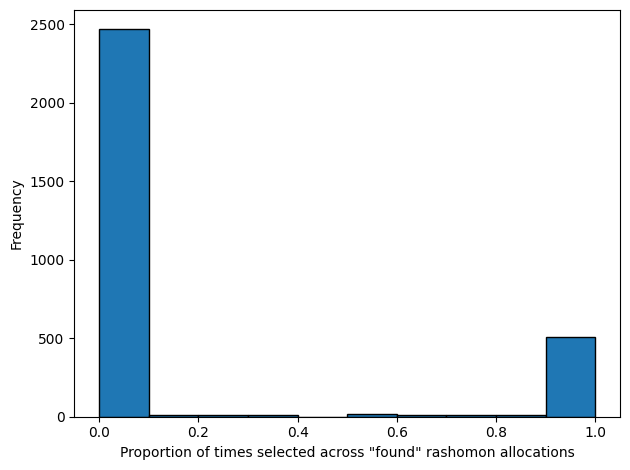

In [40]:
q = []
uq = []

for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        test_data = data.loc[data["person_id"].isin(people)].copy()
        qualified_selections = dict.fromkeys(test_data.loc[test_data[QUALIFICATION_COLUMN]==1, "person_id"].to_list(), 0)
        unqualified_selections = dict.fromkeys(test_data.loc[test_data[QUALIFICATION_COLUMN]==0, "person_id"].to_list(), 0)

        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "selected"].to_list()
        for a in allocations:
            for p in a:
                if p in qualified_selections:
                    qualified_selections[p] += 1
                else:
                    unqualified_selections[p] += 1

        q += list(np.array(list(qualified_selections.values()))/len(allocations))
        uq += list(np.array(list(unqualified_selections.values()))/len(allocations))

import matplotlib.pyplot as plt

# Create the histogram
plt.hist(uq, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('Proportion of times selected across "found" rashomon allocations')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.savefig('test.jpg')
plt.show()

#### Individual Fairness -- Qualified and Unqualified Selections

In [28]:
qualified_avg = []
qualified_std = []
unqualified_avg = []
unqualified_std = []

for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        test_data = data.loc[data["person_id"].isin(people)].copy()
        qualified_selections = dict.fromkeys(test_data.loc[test_data[QUALIFICATION_COLUMN]==1, "person_id"].to_list(), 0)
        unqualified_selections = dict.fromkeys(test_data.loc[test_data[QUALIFICATION_COLUMN]==0, "person_id"].to_list(), 0)

        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "selected"].to_list()
        for a in allocations:
            for p in a:
                if p in qualified_selections:
                    qualified_selections[p] += 1
                else:
                    unqualified_selections[p] += 1

        qualified_selections = np.array(list(qualified_selections.values()))/len(allocations)
        unqualified_selections = np.array(list(unqualified_selections.values()))/len(allocations)
        
        qualified_avg.append(np.mean(qualified_selections))
        qualified_std.append(np.std(qualified_selections))
        unqualified_avg.append(np.mean(unqualified_selections))
        unqualified_std.append(np.std(unqualified_selections))
print(np.mean(qualified_avg))
print(np.mean(qualified_std))
print(np.mean(unqualified_avg))
print(np.mean(unqualified_std))

0.6050566151342446
0.46820337321447136
0.1794046301938128
0.3621676947369631


#### Individual Fairness -- Num Chronic Illnesses

In [22]:
all_metric = []

for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        test_data = data.loc[data["person_id"].isin(people)].copy()
        
        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "selected"].to_list()
        metric = []
        for a in allocations:
            ind_fairness = 0
            for j,p in test_data.iterrows():
                neighbors = test_data.loc[test_data["gagne_sum_t"]==p["gagne_sum_t"], "person_id"].to_list()
                neighbors_selected = 0
                for n in neighbors:
                    if n in a:
                        neighbors_selected += 1
                        
                p_selected = 0
                if p["person_id"] in a:
                    p_selected = 1
                ind_fairness += (np.abs(p_selected - neighbors_selected/len(neighbors)))
            metric.append(ind_fairness/len(test_data))
        all_metric.append(metric) 

all_metric_flattened = [m for metric in all_metric for m in metric]
all_metric_min = [min(metric) for metric in all_metric]
print(np.nanmean(all_metric_flattened))
print(np.nanstd(all_metric_flattened))
print(np.nanmean(all_metric_min))

0.23798906906618253
0.03227925108559802
0.227132377548405


#### Group Fairness -- % Highest Risk Patients That Are Black

In [23]:
all_props = []

black_people = data.loc[data["race"]==1, "person_id"].to_list()

for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "selected"].to_list()
        props = []
        for a in allocations:
            black_selected = 0
            for p in a:
                if p in black_people:
                    black_selected += 1
            props.append(black_selected/len(a))
        all_props.append(props)

all_props_flattened = [p for props in all_props for p in props]
all_props_max = [max(props) for props in all_props]
print(np.nanmean(all_props_flattened))
print(np.nanstd(all_props_flattened))
print(np.nanmean(all_props_max))

0.14062780269058295
0.06599515680547101
0.1668


In [18]:
best_prop = []
for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        k = len(selected)
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        
        test_data = data.loc[data["person_id"].isin(people)].copy()
        test_data = test_data[["person_id", QUALIFICATION_COLUMN, "race"]].reset_index(drop=True).copy()
        
        k_prime = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "k'"].max()
        qualified_black = test_data[(test_data["race"]==1)&(test_data[QUALIFICATION_COLUMN]==1)]
        unqualified_black = test_data[(test_data["race"]==1)&(test_data[QUALIFICATION_COLUMN]==0)]
        qualified_white = test_data[(test_data["race"]==0)&(test_data[QUALIFICATION_COLUMN]==1)]
        unqualified_white = test_data[(test_data["race"]==0)&(test_data[QUALIFICATION_COLUMN]==0)]

        # Select as many black patients as possible under k' and (k-k') restrictions
        black_selected = 0
        if len(qualified_black)>=k_prime:
            black_selected += k_prime
        else:
            black_selected += len(qualified_black)
        if len(unqualified_black)>=(k-k_prime):
            black_selected += (k-k_prime)
        else:
            black_selected += len(unqualified_black)
        best_prop.append(black_selected/k)
print(np.mean(best_prop))
print(np.std(best_prop))

0.36519999999999997
0.11657169467756742


#### Group Fairness -- Difference in # Chronic Illnesses Among Selected Patients By Race

In [16]:
all_ratios = []

black_people = data.loc[data["race"]==1, "person_id"].to_list()

for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        test_data = data.loc[data["person_id"].isin(people)].copy()

        ratio = []
        allocations = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "selected"].to_list()
        for a in allocations:
            white_num_illnesses = test_data.loc[(test_data["race"]==0)&(test_data["person_id"].isin(a)), "gagne_sum_t"].mean()
            black_num_illnesses = test_data.loc[(test_data["race"]==1)&(test_data["person_id"].isin(a)), "gagne_sum_t"].mean()
            ratio.append(black_num_illnesses/white_num_illnesses)
        all_ratios.append(ratio)

all_ratios_flattened = [r for ratios in all_ratios for r in ratios]
all_ratios_min = [min(ratios) for ratios in all_ratios]
print(np.nanmean(all_ratios_flattened))
print(np.nanstd(all_ratios_flattened))
print(np.nanmean(all_ratios_min))

1.4923815410840582
0.5541476531508203
1.4296089186531462


In [17]:
best_ratio = []
for seed in df["seed"].unique():
    for iteration in df["iteration"].unique():
        selected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "selected"].values[0]
        k = len(selected)
        unselected = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration)&(df["allocation_idx"]==0), "unselected"].values[0]
        people = selected + unselected
        
        test_data = data.loc[data["person_id"].isin(people)].copy()
        test_data = test_data[["person_id", QUALIFICATION_COLUMN, "race", "gagne_sum_t"]].reset_index(drop=True).copy()
        
        k_prime = df.loc[(df["seed"]==seed)&(df["iteration"]==iteration), "k'"].max()
        qualified = test_data[(test_data[QUALIFICATION_COLUMN]==1)]
        unqualified = test_data[(test_data[QUALIFICATION_COLUMN]==0)]

        qualified = qualified.sort_values(by=["gagne_sum_t"], ascending=False).reset_index(drop=True)
        unqualified = unqualified.sort_values(by=["gagne_sum_t"], ascending=False).reset_index(drop=True)

        # Select based on highest chronic illnesses, under k' and (k-k') restrictions
        selected = pd.concat([qualified.loc[:k_prime-1], unqualified.loc[:(k-k_prime)-1]])
        white_num_illnesses = selected.loc[(test_data["race"]==0), "gagne_sum_t"].mean()
        black_num_illnesses = selected.loc[(test_data["race"]==1), "gagne_sum_t"].mean()
        best_ratio.append(black_num_illnesses/white_num_illnesses)
print(np.nanmean(best_ratio))
print(np.nanstd(best_ratio))

1.034217242770166
0.4016658781216366
